# Project 2: Regression for Prediction Problems

Team members: Hero Ashman, Madeleine Parker, Elleni Hailu, Yael Nidam.

In this report we use data from the CDC and the American Community Survey to predict diabetes rates at the county level. This report should inform decisions about where to target a pilot diabetes prevention program. 

## 1. Exploratory Data Analysis
Our data set is a combination of variables from the CDC and the ACS at the county level. We have information from 3220 counties. Variables include the population counts of people with diabetes, who are obese, and who are physically inactive, and population counts of people by race, ethnicity, age, and sex. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)

In [4]:
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv")
diabetes.head()

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
0,Autauga County,Alabama,1001,5178,13489,12525,76.5,55200,54170,1030,...,39614,9403,8050,41831,20054,21777,92.1,8050,3488,4562
1,Baldwin County,Alabama,1003,16707,48542,40024,86.6,208107,204535,3572,...,155502,49811,40665,162430,78104,84326,92.6,40665,18870,21795
2,Barbour County,Alabama,1005,3400,8009,5431,76.2,25782,25429,353,...,19394,5658,4634,20346,10923,9423,115.9,4634,2004,2630
3,Bibb County,Alabama,1007,2371,6534,5827,80.5,22527,22340,187,...,16864,4323,3661,17868,9578,8290,115.5,3661,1633,2028
4,Blount County,Alabama,1009,6282,14227,14365,79.7,57645,56710,935,...,42232,12400,10233,44177,21595,22582,95.6,10233,4540,5693


In [5]:
# number of rows 
len(diabetes)

3220

In [6]:
#View all column names
cols = diabetes.columns.tolist()
#cols

In [7]:
# list of variable names (long)
#list(diabetes.columns.values)

# type of the three variables we are concerned are strings
diabetes.dtypes[3:6]


Diabetes_Number               object
Obesity_Number                object
Physical_Inactivity_Number    object
dtype: object

**Data Cleaning**

While the population counts are all numeric, as expected, the counts for diabetes, people who are obese, and people who are inactive are strings. Some of these columns contain missing data, which is recorded as the string "No Data". We convert these columns to floats, coercing any rows with non-numeric strings in to NaN.  There is 1 row with missing diabetes counts. There are 78 rows with missing counts for Physically Inactive and Obese. 

In [8]:
diabetes['Diabetes_Number'] = pd.to_numeric(arg=diabetes['Diabetes_Number'], errors='coerce')
diabetes['Obesity_Number'] = pd.to_numeric(arg=diabetes['Obesity_Number'], errors='coerce')
diabetes['Physical_Inactivity_Number'] = pd.to_numeric(arg=diabetes['Physical_Inactivity_Number'], errors='coerce')

diabetes.dtypes[3:6]


Diabetes_Number               float64
Obesity_Number                float64
Physical_Inactivity_Number    float64
dtype: object

In [9]:
# missing counts for key variables
diabetes.isnull().sum()[3:6]

Diabetes_Number                1
Obesity_Number                78
Physical_Inactivity_Number    78
dtype: int64

**Distribution of Diabetes Cases** 

We start our report with some descriptive plots. Our goal here is to explore variation in diabetes numbers across counties. We also look at a couple of predictors that we suspect might be important for prediction later on.  

We plot a histogram of diabetes cases as the county level. We plot this both as number of cases and as number of cases per 100 people, as the counties vary in population size. 

In [17]:
# calculate diabetes cases per 100 people
diabetes['diabetes_per100'] = diabetes['Diabetes_Number']/diabetes['race_total population']*100

# calculate log of diabetes cases
diabetes['ln_diabetes'] = np.log(diabetes["Diabetes_Number"])

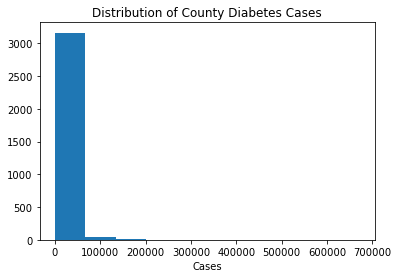

In [12]:
#diabetes cases across counties
#sns.histplot(data = diabetes, x = 'Diabetes_Number')
plt.hist(diabetes['Diabetes_Number'])
plt.title("Distribution of County Diabetes Cases")
plt.xlabel("Cases");

The plot above shows that the distribution of cases across counties is extremely right skewed, likely driven by counties with very large populations. Logging the case numbers makes the distribution easier to see. 

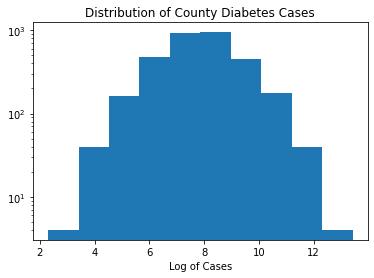

In [18]:
#sns.histplot(data = diabetes, x = 'Diabetes_Number', log_scale= True)
plt.hist(diabetes['ln_diabetes'], log = True)
plt.title("Distribution of County Diabetes Cases")
plt.xlabel("Log of Cases");

The plot below shows that the percentage of people with diabetes is roughly normally distributed across counties, with a mean around 10%. This corresponds to the percentage of the population with diabetes reported by the [American Diabetes Association](https://www.diabetes.org/resources/statistics/statistics-about-diabetes). 

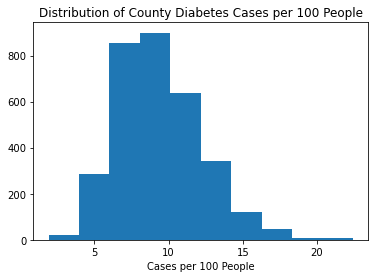

In [19]:
# diabetes per 100 people
#sns.histplot(data = diabetes, x = 'diabetes_per100', kde = True)
plt.hist(diabetes["diabetes_per100"])
plt.title("Distribution of County Diabetes Cases per 100 People")
plt.xlabel("Cases per 100 People");

**Diabetes and Level of Inactivity**

We suspect there might be a relationship between diabetes and level of inactivity. To explore this, we plot the linear regression line of physical inactivity on diabetes cases, at the county level. We first log both numbers. The plot below also includes a scatter plot of the underlying data. There is a linear relationship between number of diabetes cases and number of people who are physically inactive. There is greater variation around the middle of the distribution. This implies that the number of inactive people might not be a good linear predictor for the number of diabetes cases in counties with cases around the middle of the distribution. 

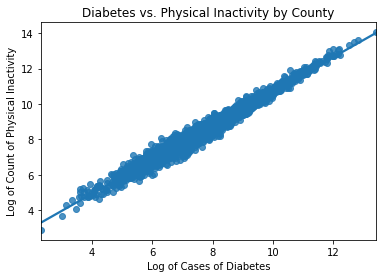

In [20]:
# take log of physically inactive
diabetes['ln_inactive'] = np.log(diabetes["Physical_Inactivity_Number"])

sns.regplot(data = diabetes, x = 'ln_diabetes', y = 'ln_inactive', scatter = True)
plt.title("Diabetes vs. Physical Inactivity by County")
plt.xlabel("Log of Cases of Diabetes")
plt.ylabel("Log of Count of Physical Inactivity");

There is similarly a linear relationship between diabetes cases and the number of obese people at the county level. Again, this relationship seems weakest around the middle of the distribution, where there is greater variation, and it is not clear that increasing cases of obesity would predict increasing cases of diabetes. 

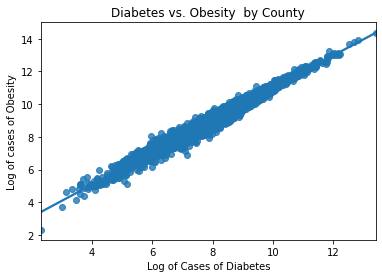

In [21]:
# Diabetes and obesity
diabetes['ln_obesity'] = np.log(diabetes["Obesity_Number"])

sns.regplot(data = diabetes, x = 'ln_diabetes', y = 'ln_obesity', scatter = True)
plt.title("Diabetes vs. Obesity  by County")
plt.xlabel("Log of Cases of Diabetes")
plt.ylabel("Log of cases of Obesity");

**Diabetes and Demographic Characteristics**

Our data contains county population counts by sex, race, and age (and interactions of all three). It is possible that upstream social factors that vary by gender, such as diet or activity levels, impact rates of diabetes. Although we do not observe the rates of diabetes differentially for men and women (the only genders reported in the ACS), we can see if counties with a higher male to female ratio have higher or lower rates of diabetes. For this, we create a dummy variable indicating if a county has more or equal number of women than men (female_cnty). We then plot a box-and-whisker diagram of cases per 100 people for the two types of county.

The plot below shows that for counties with equal or higher numbers of women than men, their rate of diabetes is slightly higher (orange plot). However, there is not a large difference and it may not be significant.  


In [22]:
# dummy for a county having more or equal number of women to men
diabetes['female_cnty'] = 1*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] <=100) \
+ 0*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] > 100)
#diabetes['female_cnty']

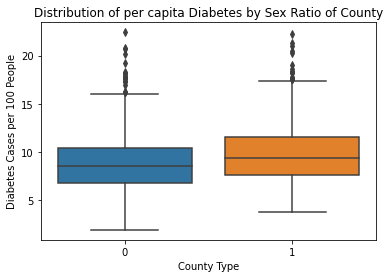

In [40]:
sns.boxplot(data = diabetes, x = 'female_cnty', y = 'diabetes_per100')
plt.title('Distribution of per capita Diabetes by Sex Ratio of County')
plt.xlabel('County Type')
plt.ylabel('Diabetes Cases per 100 People');

## 2. Prepare to Fit Models

In this next section we clean the data, partition it and investigate whether there are any features we should remove prior to fitting the models.

### A. Clean data

First, we remove geographic features and variables we created for data exploration.

In [23]:
# We create a new variable to store the clean dataset
diabetes_clean = diabetes 

# We drop variables that shouldn't be used in the analysis
diabetes_clean = diabetes_clean.drop([ 'State' ,'County','CountyFIPS' # columns with geographic information
                                       ,'diabetes_per100','ln_diabetes','ln_inactive','ln_obesity','female_cnty' #Data exploration variables
                                     
                                     ], axis=1)
diabetes_clean.shape

(3220, 92)

Next, we ensure all datatypes are numeric.

In [25]:
#Checkout all datatypes that are object
diabetes_clean.loc[:, diabetes_clean.dtypes == np.object]
#We see only one column that's misidentified as object while it is a float

#First, we set '-' response as Nan, and then we define the satatype as float
diabetes_clean["sex and age_total population_65 years and over_sex ratio (males per 100 females)"]= diabetes_clean["sex and age_total population_65 years and over_sex ratio (males per 100 females)"].str.replace("-", "nan", case = False) 
diabetes_clean["sex and age_total population_65 years and over_sex ratio (males per 100 females)"]=diabetes_clean["sex and age_total population_65 years and over_sex ratio (males per 100 females)"].astype(float)

### B. Partition data

We start by separating the response from the features:

In [26]:
X = diabetes_clean.drop(['Diabetes_Number'], axis=1)
Y = diabetes_clean['Diabetes_Number']


#### Training Set

Since our dataset is small, we are interested in saving a relatively large portion (40%) of it for the test dataset, so that we can reduce overfitting. 

In [27]:
from sklearn.model_selection import train_test_split

# set the random seed to ensure that results are similar across different runs and machines. 
np.random.seed(10)

# split the data 4 ways:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.60, test_size=0.40)

In [28]:
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)

Shape of X train is (1932, 91)
Shape of y_train is (1932,)
Shape of X_test is (1288, 91)
Shape of y_test is (1288,)


#### Validation Set

In order to tune our hyperparamters, we also set aside a validation data set from the training data. We subset 75% of our training data as validaton data. This gives a total split of training:validation:test as 45:15:40. 

In [29]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

In [30]:
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of y_validate is", y_validate.shape)

Shape of X train is (1449, 91)
Shape of y_train is (1449,)
Shape of X_validate is (483, 91)
Shape of y_validate is (483,)


### C. Feature selection

We drop variables that are highly correlated with the response from the training and validation sets. Above, we showed that there is a strong linear relationship between diabetes cases and physically inactive cases and obesity cases. When training a model, we anticipate that it will use only these features to predict diabetes cases. To avoid this (why?), we drop them from our training and validation sets. 


In [31]:
X_train    =    X_train.drop(['Physical_Inactivity_Number','Obesity_Number' ], axis=1)
X_validate = X_validate.drop(['Physical_Inactivity_Number','Obesity_Number' ], axis=1)